In [1]:
import os
import pandas as pd

base_path = "/Users/nickeastham/PlantVillage-Dataset/raw/color"

photo_array = []
condition_array = []
disease_array = []
type_of_plant_array = []

for file in os.listdir(base_path):
    if file != ".DS_Store":
        dir_photos = os.listdir(os.path.join(base_path, file))

        # Determine the condition (healthy or not)
        if "healthy" in file:
            condition = 1
        else:
            condition = 0

        # Split the file name to extract disease and type_of_plant information
        split_result = file.split("___")
        if len(split_result) < 2:
            print(f"Error splitting file name: {file}")
            continue

        disease = split_result[1]
        type_of_plant = split_result[0]

        # Iterate through photos in the directory
        for photo in dir_photos:
            
            full_photo_path = os.path.join(base_path, file, photo)
            
            condition_array.append(condition)
            disease_array.append(disease)
            photo_array.append(full_photo_path)
            type_of_plant_array.append(type_of_plant)

df = pd.DataFrame({
    'Photo': photo_array,
    'Disease': disease_array,
    'Type of Plant': type_of_plant_array,
    'Condition': condition_array
})

df.head()

,Photo,Disease,Type of Plant,Condition
0,/Users/nickeastham/PlantVillage-Dataset/raw/co...,healthy,Strawberry,1
1,/Users/nickeastham/PlantVillage-Dataset/raw/co...,healthy,Strawberry,1
2,/Users/nickeastham/PlantVillage-Dataset/raw/co...,healthy,Strawberry,1
3,/Users/nickeastham/PlantVillage-Dataset/raw/co...,healthy,Strawberry,1
4,/Users/nickeastham/PlantVillage-Dataset/raw/co...,healthy,Strawberry,1


In [2]:
print(df.dtypes)

Photo            object
Disease          object
Type of Plant    object
Condition         int64
dtype: object


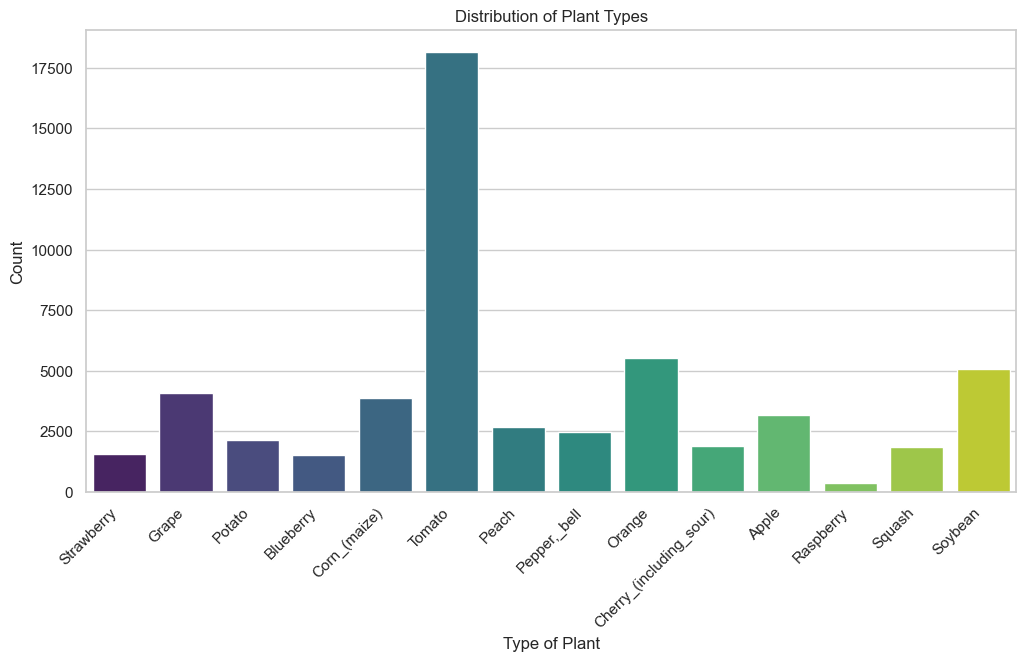

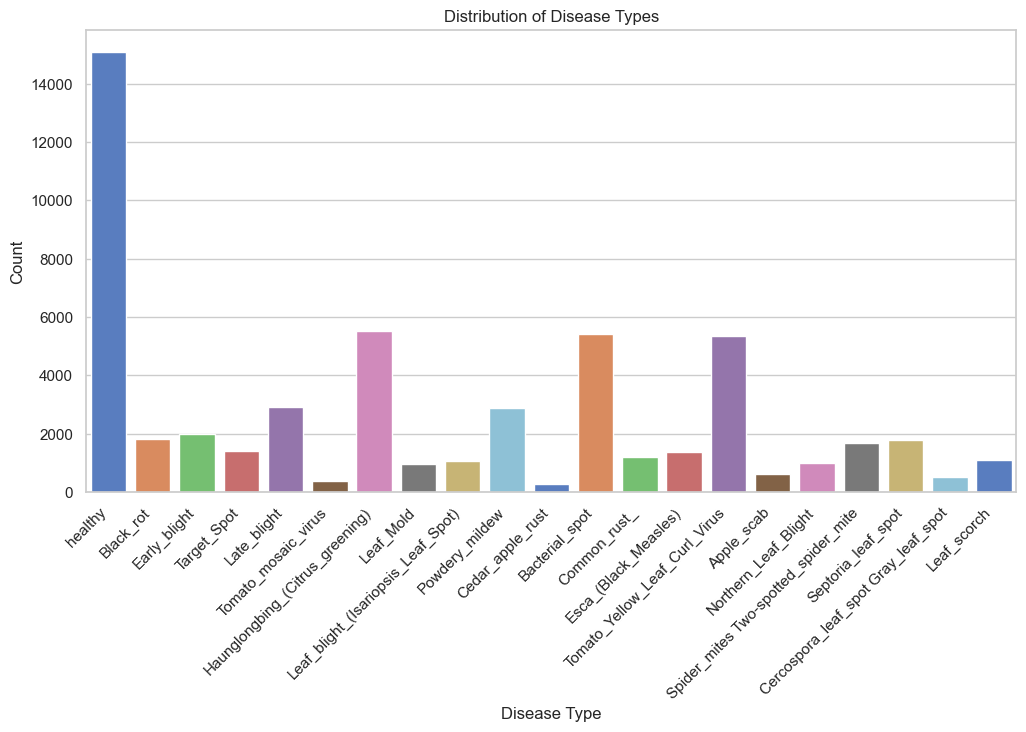

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.set(style="whitegrid")


plt.figure(figsize=(12, 6))
sns.countplot(x='Type of Plant', data=df, palette='viridis')
plt.title('Distribution of Plant Types')
plt.xlabel('Type of Plant')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right') 
plt.show()


plt.figure(figsize=(12, 6))
sns.countplot(x='Disease', data=df, palette='muted')
plt.title('Distribution of Disease Types')
plt.xlabel('Disease Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right') 
plt.show()

In [4]:
df.head()

,Photo,Disease,Type of Plant,Condition
0,/Users/nickeastham/PlantVillage-Dataset/raw/co...,healthy,Strawberry,1
1,/Users/nickeastham/PlantVillage-Dataset/raw/co...,healthy,Strawberry,1
2,/Users/nickeastham/PlantVillage-Dataset/raw/co...,healthy,Strawberry,1
3,/Users/nickeastham/PlantVillage-Dataset/raw/co...,healthy,Strawberry,1
4,/Users/nickeastham/PlantVillage-Dataset/raw/co...,healthy,Strawberry,1


In [5]:
shuffled = df.sample(frac=1, random_state=123).reset_index(drop=True)

subset = shuffled.head(100)

train_set = subset.head(80)
test_set = subset.tail(20)

In [6]:
train_set.loc[:, 'Condition'] = train_set['Condition'].copy()
test_set.loc[:, 'Condition'] = test_set['Condition'].copy()

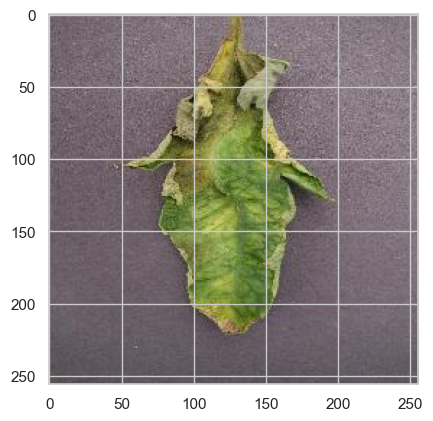

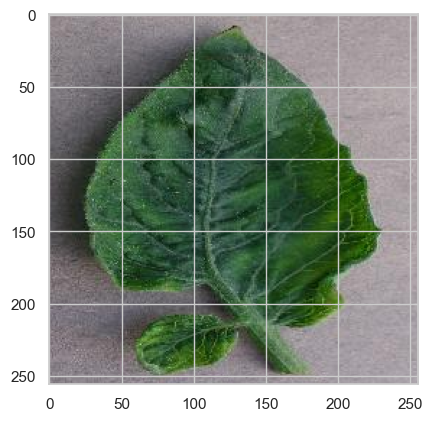

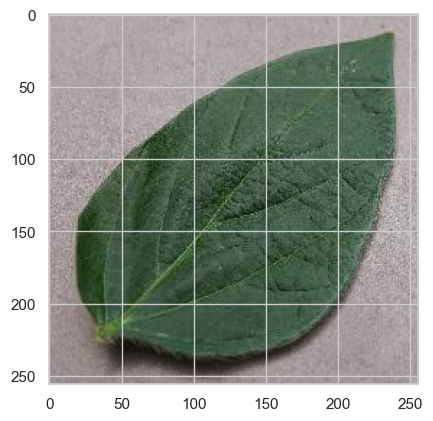

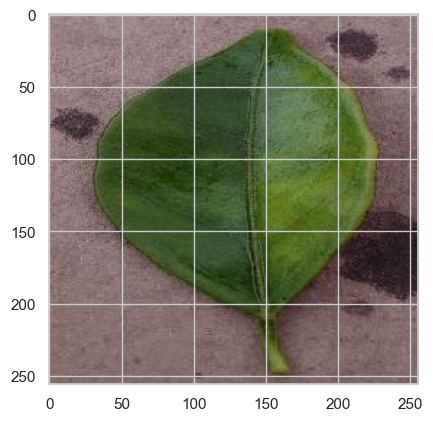

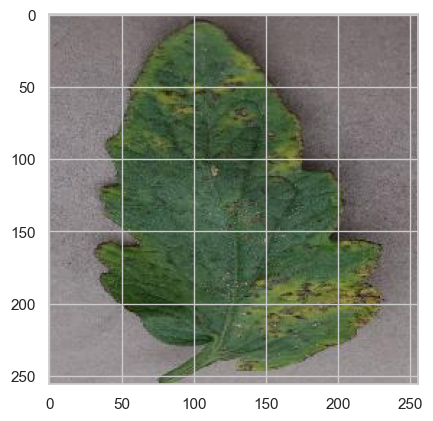

In [7]:
X_train_list = list(train_set['Photo'])
X_test_list = list(test_set['Photo'])

y_train_list = list(train_set['Condition'])
y_test_list = list(test_set['Condition'])

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for i in range(5):
    img_path = X_train_list[i]
    img = mpimg.imread(img_path)
    
    plt.imshow(img)
    plt.show()

In [13]:
import tensorflow as tf

def parse(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=3)    
    return image_decoded, label

train_data = tf.data.Dataset.from_tensor_slices((X_train_list, y_train_list))
train_data = train_data.map(parse).batch(100)

test_data = tf.data.Dataset.from_tensor_slices((X_test_list, y_test_list))
test_data = test_data.map(parse).batch(100)

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))  # Two neurons for binary classification

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 246016)            0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [15]:
from tensorflow.keras import optimizers

learning_rate = 0.001
optimizer = optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
plant_model = model.fit(train_data, epochs=3, validation_data=test_data)
test_loss, test_acc = model.evaluate(test_data)

print(f"Test Accuracy: {test_acc}")

Epoch 1/3
1/1 [==============================] - 7s 7s/step - loss: 6.9610 - accuracy: 0.6375 - val_loss: 15170.1699 - val_accuracy: 0.1500
Epoch 2/3
1/1 [==============================] - 5s 5s/step - loss: 11454.6328 - accuracy: 0.2750 - val_loss: 4047.0093 - val_accuracy: 0.1500
Epoch 3/3
1/1 [==============================] - 0s 362ms/step - loss: 328.4447 - accuracy: 0.8500
Test Accuracy: 0.8500000238418579
